# Lab 6
## Ian Grant

In [21]:
import geopandas as gp
import requests
import matplotlib.pyplot as plt

## API to GeoPackage pipeline 

First, I developed a tool to take URLs corrresponding to NYC Open
Data's API and return a geopackage with each dataset as a layer.

The first two functions automatically create a GeoDataFrame given a URL and a limit (i.e. the number of rows to read from the API).

In [22]:
def json_response(url, limit=500000):
    # Limit will determine how many rows are read
    with requests.get(url, params=my_params) as response:
        return response.json()

In [23]:
def gdf_from_url(url, limit=500000):
    response = json_response(url, limit)
    gdf = gp.GeoDataFrame.from_features(response)
    return gdf

The next function applies the functions above to a dict of URLs of the form {layer_name : URL}; the user chooses the 'layer_name' and then uses it to refer to that dataset. It returns a dict of GeoDataFrames of the form {layer_name : GeoDataFrame}.

In [24]:
def gdf_dict(url_dict, max_size=500000):
    ans = {}
    for key in url_dict:
        ans[key] = gdf_from_url(url_dict[key], max_size)
    return ans

The next function writes a dict of GeoDataFrames (in the format produced by the function above) to a GeoPackage. Each GeoDataFrame is a separate layer, and the layer names correspond to the layer_names in the dict.

In [25]:
def gdf_dict_to_gpkg(gdf_dict, path, max_size=500000):
    for key in gdf_dict:
        gdf_dict[key].to_file(path, layer=key, driver="GPKG")

The final function combines the functions above so that the user can directly input a dict of URLs and receive a GeoPackage. 

Since a dict of GeoDataFrames is generated as part of the process of generating the GeoPackage, the function returns the GeoDataFrames so that they can be used for further analysis. 

In [26]:
def urls_to_gpkg(url_dict, path, max_size=500000):
    my_gdf_dict = gdf_dict(url_dict, max_size)
    gdf_dict_to_gpkg(my_gdf_dict, path)
    return my_gdf_dict

Let's test out the function with some bike-related datasets.

In [27]:
my_urls = {
    "vision_zero": "https://data.cityofnewyork.us/resource/h9gi-nx95.geojson",
    "bike_routes": "https://data.cityofnewyork.us/resource/s5uu-3ajy.geojson",
    "street_centerline": "https://data.cityofnewyork.us/resource/8rma-cm9c.geojson",
    "bikes_in_buildings": "https://data.cityofnewyork.us/resource/scjj-6yaf.geojson",
    "priority_bike_districts": "https://data.cityofnewyork.us/resource/h6b2-3v9f.geojson",
    "census": "https://data.cityofnewyork.us/resource/63ge-mke6.geojson",
}

In [28]:
my_gdf_dict = urls_to_gpkg(my_urls, "my_bike_map.gpkg")

This geopackage can be opened in QGIS, and the datasets
corresponding to the API requests will automatically be imported as
layers. 

## GeoDataFrame data types

We can also use some of the functions defined above to explore what
kind of data a GeoDataFrame contains.

In [29]:
print(my_gdf_dict['census'])

                                               geometry     shape_area  \
0     MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...   1844421.2457   
1     MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...  972312.140355   
2     MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...  2582705.23446   
3     MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...  1006116.58429   
4     MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...  1226206.24719   
...                                                 ...            ...   
2320  MULTIPOLYGON (((-74.08709 40.64033, -74.08721 ...  2674908.16878   
2321  MULTIPOLYGON (((-73.93686 40.74842, -73.93664 ...  1909109.97602   
2322  MULTIPOLYGON (((-73.90971 40.74975, -73.91163 ...    8783519.361   
2323  MULTIPOLYGON (((-73.87477 40.73463, -73.87444 ...  3028835.93228   
2324  MULTIPOLYGON (((-73.86448 40.73109, -73.86455 ...  2999984.92497   

                                                ntaname  \
0     The Battery-Governors Island-Ellis Island-Libe

We can see that the census GeoDataFrame contains multipolygons
associated with 13 other columns of data.

But is this the only type of geometry in the data frame? We can
check this with the following function.

In [30]:
# Return a list of all the unique geometry types in a GeoDataFrame.
def gdf_geo_types(gdf):
    return {geom.geom_type for geom in gdf.geometry}

In [31]:
# We can see that the census GeoDataFrame only contains MultiPolygons.
print(gdf_geo_types(my_gdf_dict['census']))

{'MultiPolygon'}


Meanwhile, the bike routes GeoDataFrame only contains
MultiLineStrings.

In [32]:
print(gdf_geo_types(my_gdf_dict['bike_routes']))

{'MultiLineString'}


## Plotting

Next, I made a function for quickly plotting some layers from a GeoDataFrame. The idea is to provide a quick way to verify that the data looks right rather than to create a finished map product.

In [33]:

def quickplot_gdf_dict(gdfs: dict, to_plot: list, colors: list):
    """Plots the GeoDataFrames within gdfs that are named in to_plot."""

    fig, ax = plt.subplots()
    ax.set_aspect("equal")

    i = 0
    
    # Plot each GeoDataFrame, cycling through the colors.
    # Colors are reused if there are more GeoDataFrames than colors.
    for key in to_plot:
        gdfs[key].plot(ax=ax, color=colors[i % len(colors)], edgecolor='black', linewidth=.4)

        # Reuse colors if there are more layers than colors
        i += 1

Here, we'll make a plot using the census data, priority bike
districts, and bike route.

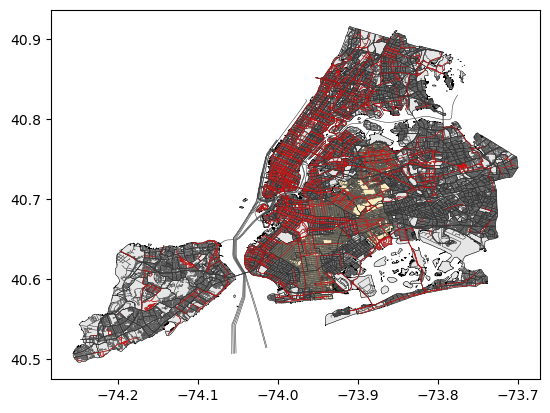

In [34]:
# Note that the order of to_plot corresponds to the plot's drawing
# order, so we want the lower layers first.
my_colors = ["#e6e6e6", "#fcecc0", "#3b3b3b", "#e80c0c"]
to_plot = ["census", "priority_bike_districts", "street_centerline", "bike_routes"]
plt.close()
quickplot_gdf_dict(my_gdf_dict, to_plot, my_colors)
plt.show()